In [133]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv


## Import library

In [134]:
# import required library
import os
import codecs
import re
import shutil
import nltk
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
import seaborn as sns
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Concatenate, MaxPooling1D, Flatten, Embedding, LSTM, SpatialDropout1D, Dropout, MaxPooling2D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.utils import  to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax

In [135]:
# load the data
data = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [136]:
# print info of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


## Dropping Nan values

In [137]:
# removing Null values
data.dropna(inplace= True)

print("No of training data:", data.shape[0])
data.info()

No of training data: 27480
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


## Check for data imbalance

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64 

No of training examples: 27480


<BarContainer object of 3 artists>

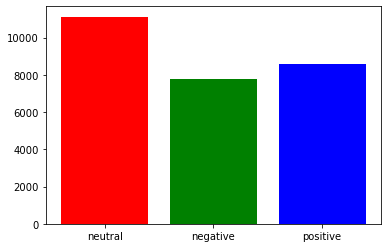

In [138]:
print(data['sentiment'].value_counts(), "\n")
print("No of training examples:", data.shape[0])

# plot class distribution
sentiments = []
sentiment_count = []
for i in data.sentiment.unique():
    sentiments.append(i)
    sentiment_count.append(data.sentiment[data.sentiment==i].count())
plt.bar(sentiments, sentiment_count, color = ["r", "g", "b"])

In [139]:
data["sentiment"].replace("neutral", 1, inplace = True)
data["sentiment"].replace("positive", 2, inplace = True)
data["sentiment"].replace("negative", 0, inplace = True)
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,088c60f138,my boss is bullying me...,bullying me,0
3,9642c003ef,what interview! leave me alone,leave me alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0


## Preprocess text data

In [140]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

X_processed = preprocess_text(data['text'])

100%|██████████| 27480/27480 [00:01<00:00, 16463.25it/s]


In [141]:
data['preprocessed_text'] = X_processed
data.head(5)

,textID,text,selected_text,sentiment,preprocessed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,0,boss bullying
3,9642c003ef,what interview! leave me alone,leave me alone,0,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,sons put releases already bought


In [142]:
# removing sentences of length less than 4
data_processed = data[data['preprocessed_text'].str.len()>3]
print('The shape of data :', data_processed.shape)

X = data_processed["preprocessed_text"]
Y = data_processed["sentiment"]

print('No. of datapoints in X', len(X))
print('No of labels in Y', len(X))

The shape of data : (27297, 5)
No. of datapoints in X 27297
No of labels in Y 27297


## Selecting Maximum Sequence length

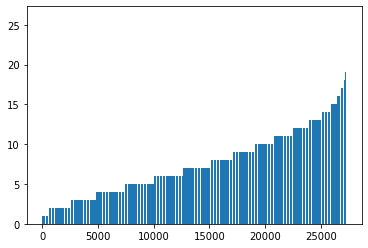

In [143]:
# plot doc word length
sent_len = X.apply(lambda x:len(str(x).split(' ')))
plt.bar(range(27297), sent_len.sort_values().values)
plt.show()

In [144]:
for i in range(1, 50):
    print(f"{95+i/10}th percentile length: ", np.percentile(sent_len.sort_values().values, 95+i/10))

95.1th percentile length:  15.0
95.2th percentile length:  15.0
95.3th percentile length:  15.0
95.4th percentile length:  15.0
95.5th percentile length:  15.0
95.6th percentile length:  15.0
95.7th percentile length:  15.0
95.8th percentile length:  15.0
95.9th percentile length:  15.0
96.0th percentile length:  15.0
96.1th percentile length:  15.0
96.2th percentile length:  15.0
96.3th percentile length:  15.0
96.4th percentile length:  15.0
96.5th percentile length:  15.0
96.6th percentile length:  15.0
96.7th percentile length:  15.0
96.8th percentile length:  15.0
96.9th percentile length:  16.0
97.0th percentile length:  16.0
97.1th percentile length:  16.0
97.2th percentile length:  16.0
97.3th percentile length:  16.0
97.4th percentile length:  16.0
97.5th percentile length:  16.0
97.6th percentile length:  16.0
97.7th percentile length:  16.0
97.8th percentile length:  16.0
97.9th percentile length:  16.0
98.0th percentile length:  16.0
98.1th percentile length:  16.0
98.2th p

So here I am taking 20 as the maximum sequence length and truncate all the sequences greater than it.

## Tokenization and padding

In [145]:
# tokenize and pad senences
t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(X.values)

X_ = t.texts_to_sequences(data_processed['preprocessed_text'])    # sequence of words for each sentence according to their preference in dictationary
X_ = pad_sequences(X_, maxlen = 20)
print(X_)

[[    0     0     0 ...     0 10254    12]
 [    0     0     0 ...    37  1338  2173]
 [    0     0     0 ...     0  1240 10255]
 ...
 [    0     0     0 ...   539   752  2720]
 [    0     0     0 ...     0     0   581]
 [    0     0     0 ...  2174   143   550]]


In [146]:
# one hot encoding labels
Y = to_categorical(Y, num_classes = 3)
Y.shape

(27297, 3)

In [147]:
enbadding_dims = 128
lstm_out = 300

vocab_size = len(t.word_index) + 1
print('Vacubalary size: ', vocab_size)

Vacubalary size:  25783


# LSTM Model

## Build Model

In [148]:
model = Sequential()
model.add(Embedding(vocab_size, enbadding_dims,input_length = X_.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, return_sequences = True))
model.add(LSTM(400, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 128)           3300224   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 300)           514800    
_________________________________________________________________
lstm_7 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
dense_24 (Dense)             (None, 32)                12832     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_26 (Dense)             (None, 3)                

## fit the model

In [149]:
batch_size = 32
H = model.fit(X_, Y, epochs = 4, batch_size=batch_size, verbose = 1, validation_split = 0.2)

Epoch 1/4
683/683 [==============================] - 198s 290ms/step - loss: 0.8493 - accuracy: 0.6000 - val_loss: 0.6999 - val_accuracy: 0.7130
Epoch 2/4
683/683 [==============================] - 198s 290ms/step - loss: 0.6018 - accuracy: 0.7580 - val_loss: 0.7013 - val_accuracy: 0.7092
Epoch 3/4
683/683 [==============================] - 197s 288ms/step - loss: 0.4536 - accuracy: 0.8262 - val_loss: 0.7220 - val_accuracy: 0.7192
Epoch 4/4
683/683 [==============================] - 193s 282ms/step - loss: 0.3506 - accuracy: 0.8717 - val_loss: 0.7764 - val_accuracy: 0.7040


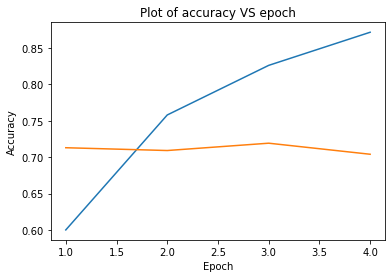

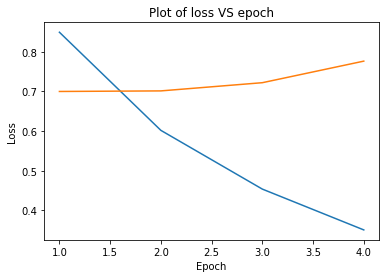

In [150]:
import matplotlib.pyplot as plt
plt.plot(range(1, 5), H.history['accuracy'])
plt.plot(range(1, 5), H.history['val_accuracy'])
plt.title('Plot of accuracy VS epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(range(1, 5), H.history['loss'])
plt.plot(range(1, 5), H.history['val_loss'])
plt.title('Plot of loss VS epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Load and prepare text data

In [151]:
test_data = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [152]:
test_text = test_data["text"]
preprocessed_test_data = preprocess_text(test_text)

test_data['preprocessed_text'] = preprocessed_test_data

X_test = t.texts_to_sequences(test_data['preprocessed_text'])
X_test = pad_sequences(X_test, maxlen = 20)
X_test

100%|██████████| 3534/3534 [00:00<00:00, 16498.89it/s]


array([[    0,     0,     0, ...,     8,    74,    22],
       [    0,     0,     0, ...,  1595,  2125,  4178],
       [    0,     0,     0, ...,  1395,   728,   702],
       ...,
       [    0,     0,     0, ...,   448, 10986,  8057],
       [    0,     0,     0, ...,    58,    10,   906],
       [    0,     0,     0, ...,   273,  2396,  3360]], dtype=int32)

In [153]:
test_label = test_data["sentiment"]
print(test_label.head())

test_data["sentiment"].replace("negative", 0, inplace = True)
test_data["sentiment"].replace("positive", 2, inplace = True)
test_data["sentiment"].replace("neutral", 1, inplace = True)
test_data.head()

0     neutral
1    positive
2    negative
3    positive
4    positive
Name: sentiment, dtype: object


,textID,text,sentiment,preprocessed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1,last session day http twitpic com 67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,2,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,2,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2,http twitpic com 4w75p like


In [154]:
test_label = test_data["sentiment"]
Y_test = to_categorical(test_label)

## Evaluation

In [155]:
model.evaluate(X_test, Y_test, verbose = 2, batch_size = 64)

56/56 - 1s - loss: 0.7857 - accuracy: 0.7119


[0.7857205271720886, 0.711941123008728]

The validation accuracy is 70.9 percent on the test  set

# LSTM Model + Glove embedding

In [156]:
# input layer
inputs = tf.keras.Input(shape=(20))

# embedding layer with pretrained weight
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs)
lstm1 = LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)(embedding)
lstm2 = LSTM(400, dropout=0.2, recurrent_dropout=0.2)(lstm1)
dense1 = Dense(32, activation = "relu")(lstm2)
dense2 = Dense(64, activation = "relu")(dense1)
out = Dense(3,activation='sigmoid')(dense2)

# build the model
model = Model(inputs=inputs, outputs=out)

In [157]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 20, 300)           7734900   
_________________________________________________________________
lstm_8 (LSTM)                (None, 20, 300)           721200    
_________________________________________________________________
lstm_9 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
dense_27 (Dense)             (None, 32)                12832     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 195 

In [158]:
H = model.fit(X_, Y, epochs = 6, batch_size=batch_size, verbose = 1, validation_split = 0.2)

Epoch 1/6
683/683 [==============================] - 168s 247ms/step - loss: 0.7397 - accuracy: 0.6834 - val_loss: 0.6472 - val_accuracy: 0.7324
Epoch 2/6
683/683 [==============================] - 165s 242ms/step - loss: 0.6279 - accuracy: 0.7406 - val_loss: 0.6271 - val_accuracy: 0.7440
Epoch 3/6
683/683 [==============================] - 164s 240ms/step - loss: 0.5898 - accuracy: 0.7621 - val_loss: 0.6094 - val_accuracy: 0.7533
Epoch 4/6
683/683 [==============================] - 164s 240ms/step - loss: 0.5037 - accuracy: 0.7959 - val_loss: 0.6297 - val_accuracy: 0.7520
Epoch 6/6
683/683 [==============================] - 165s 242ms/step - loss: 0.4500 - accuracy: 0.8203 - val_loss: 0.6622 - val_accuracy: 0.7429


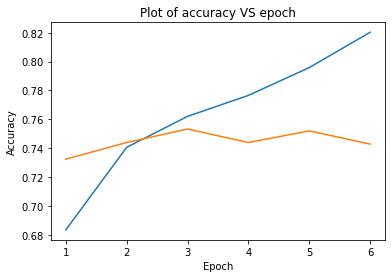

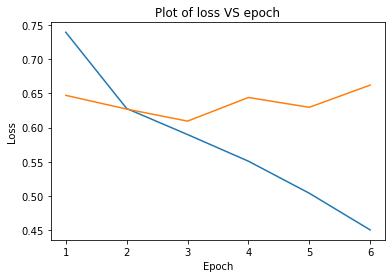

In [161]:
import matplotlib.pyplot as plt
plt.plot(range(1, 7), H.history['accuracy'])
plt.plot(range(1, 7), H.history['val_accuracy'])
plt.title('Plot of accuracy VS epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(range(1, 7), H.history['loss'])
plt.plot(range(1, 7), H.history['val_loss'])
plt.title('Plot of loss VS epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [162]:
model.evaluate(X_test, Y_test, verbose = 2, batch_size = 64)

56/56 - 1s - loss: 0.6422 - accuracy: 0.7448


[0.6422120928764343, 0.7447651624679565]

Accuracy obtrained is 74.5

# CNN Model with Glove word embedding

In [33]:
# downloading the glove word embedding
!wget "http://nlp.stanford.edu/data/glove.840B.300d.zip"

--2021-07-10 09:06:08--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-07-10 09:06:09--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-07-10 09:06:09--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [34]:
# unzip glove embedding
! unzip "./glove.840B.300d.zip.1"

Archive:  ./glove.840B.300d.zip.1
  inflating: glove.840B.300d.txt     


In [36]:
# generate word embedding dictationary
embeddings_index = {}
f = open('./glove.840B.300d.txt')
print('Loading glove vetors...')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded!!!')


Loading glove vetors...
GloVe data loaded!!!


In [37]:
# save the word embedding dictationary
import pickle
with open('embeddings_glove.pickle', 'wb') as handle:
    pickle.dump(embeddings_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [163]:
# tokenize the sentences to word
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None, 
)

# fit the tokenizer on train+val
tokenizer.fit_on_texts(data_processed['preprocessed_text'])

#get the sequence of text data of train+val
train_sequence = tokenizer.texts_to_sequences(data_processed['preprocessed_text'])
test_sequence = tokenizer.texts_to_sequences(test_data['preprocessed_text'])


# pad documents to a max length of 800 words
x_train_padded_sequence = pad_sequences(train_sequence, maxlen=20, padding='post')
x_test_padded_sequence = pad_sequences(test_sequence, maxlen=20, padding='post')

In [164]:
# vacobulary size
vocab_size = len(tokenizer.word_index) + 1
print(f'Size of vacubalory is {vocab_size}')

Size of vacubalory is 25783


In [165]:
# making embedding weight metrix by glove vectors
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [168]:
# input layer
inputs = tf.keras.Input(shape=(20))

# embedding layer with pretrained weight
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs)

# parellel convolution_block_1
conv1_1 = Conv1D(16, 3, activation=tf.nn.relu, padding = 'same')(embedding)
conv1_2 = Conv1D(16, 2, activation=tf.nn.relu, padding = 'same')(embedding)
conv1_3 = Conv1D(16, 5, activation=tf.nn.relu, padding = 'same')(embedding)

# concatenate_1
concat_1 = Concatenate(axis = 1)([conv1_1, conv1_2, conv1_3])
concat_1 = MaxPooling1D(2)(concat_1)

# parellel convolution_block_2
conv2_1 = Conv1D(24, 7, activation=tf.nn.relu, padding = 'same')(concat_1)
conv2_2 = Conv1D(24, 9, activation=tf.nn.relu, padding = 'same')(concat_1)
conv2_3 = Conv1D(24, 5, activation=tf.nn.relu, padding = 'same')(concat_1)

# concatenate_2
concat_2 = Concatenate(axis = 1)([conv2_1, conv2_2, conv2_3])
# concat_2 = MaxPooling1D(2, stride = 1)(concat_2)

# convolutiona layer
conv3 = Conv1D(10, 115, activation=tf.nn.relu, padding = 'same')(concat_2)

# flatten layer
flat = Flatten()(conv3)
# dropout layer
drop = Dropout(0.3)(flat)

# dense layers
dense_1 = Dense(256, activation=tf.nn.relu)(drop)
drop = Dropout(0.25)(dense_1)
dense_1 = Dense(100, activation=tf.nn.relu)(dense_1)

# output layer with 20 output nurons
outputs = Dense(3, activation=tf.nn.softmax)(dense_1)

# build the model
model = Model(inputs=inputs, outputs=outputs)

In [169]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 20, 300)      7734900     input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 20, 16)       14416       embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 20, 16)       9616        embedding_13[0][0]               
____________________________________________________________________________________________

In [170]:
# compile the model
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='categorical_crossentropy', metrics = ['accuracy'])

In [171]:
H = model.fit(x_train_padded_sequence, Y, epochs = 4, batch_size=batch_size, verbose = 1, validation_split = 0.2)

Epoch 1/4
683/683 [==============================] - 5s 8ms/step - loss: 0.7789 - accuracy: 0.6467 - val_loss: 0.6782 - val_accuracy: 0.7163
Epoch 2/4
683/683 [==============================] - 5s 7ms/step - loss: 0.6317 - accuracy: 0.7360 - val_loss: 0.6519 - val_accuracy: 0.7308
Epoch 3/4
683/683 [==============================] - 5s 7ms/step - loss: 0.5623 - accuracy: 0.7734 - val_loss: 0.6565 - val_accuracy: 0.7315
Epoch 4/4
683/683 [==============================] - 4s 7ms/step - loss: 0.4842 - accuracy: 0.8044 - val_loss: 0.6997 - val_accuracy: 0.7244


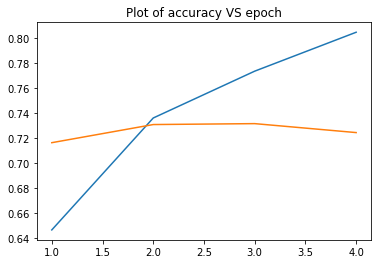

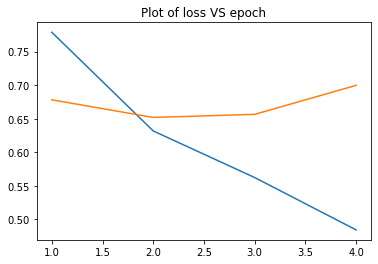

In [172]:
import matplotlib.pyplot as plt
plt.plot(range(1, 5), H.history['accuracy'])
plt.plot(range(1, 5), H.history['val_accuracy'])
plt.title('Plot of accuracy VS epoch')
plt.show()

plt.plot(range(1, 5), H.history['loss'])
plt.plot(range(1, 5), H.history['val_loss'])
plt.title('Plot of loss VS epoch')
plt.show()

## Evaluate

In [174]:
model.evaluate(x_test_padded_sequence, Y_test, verbose = 2, batch_size = 64)

56/56 - 0s - loss: 0.6857 - accuracy: 0.7184


[0.6856679320335388, 0.7184493541717529]

The Accuracy obtained is 71.84 %